In [1]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection #for plots polygons as rasters
import xarray as xr
from datetime import datetime, timedelta as delta
from matplotlib import path
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find nearest neighbor)
import os
import dask as da
from tqdm import tqdm
import glob
#for projections
from pyproj import Proj, transform, Transformer

In [2]:
#inputs----------
#path of directories
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_topo=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
dir_dws_bound=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
file_topo="DWS200m.2012.v03.nc"
file_dws_bound0="dws_boundaries_contour0.nc"
#
#general dir of interpolated forcing and displacement files
dir_post_proc_data=f"{ml_dir}post_proc_data/" 
dir_displacement="net_displacement/" 

In [4]:
#open net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",combine='nested',parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets

In [8]:
#open topo file
dsto=xr.open_dataset(dir_topo+file_topo) #topo file
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

#open DWS contours
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0


#create mask for islands
h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)

#displacement grid
xcdis0,ycdis0=dsdis.x,dsdis.y
xcdis,ycdis=np.meshgrid(xcdis0,ycdis0)


#define the transformations------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)


#lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first rotated point in the topo data in meter =0,0
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to projection)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0]
#2)add the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)

#particle grid of displacements (use for convlstm)------
xy=np.array([xcdis.flatten(),ycdis.flatten()]).T
ny,nx=xcdis.shape
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
#correction from rotation to projection:
#1)substact the first rotated topo point in meter, but give tha same as xyp0=[0,0]
#2)add the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(ny,nx,2))
xcdisp=xyp[...,0]; ycdisp=xyp[...,1] #km
#
#get coordinates in lon-lat units (WGS84 ) 
xcdisp_lon, ycdisp_lat, _ = proj.transform(xcdisp*1e3,ycdisp*1e3, ycdisp*0.)


#28992(DWS)-projection to local meter model units--------------

#matrix rotation 17degrees-----
ang2=17*np.pi/180
angs2=np.ones((2,2))
angs2[0]=np.cos(ang2); angs2[1]=np.sin(ang2)
angs2[1,0]=-np.sin(ang2); angs2[1,1]=np.cos(ang2)

#batymetry---
xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
ny,nx=xctp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T
xyl0=xyl[0,:] #the first point 
#correction from rotation to projection:
#1)substact the first rotated topo point in meter
#2)add the first local model point of the topo file
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xctl=xyl[...,0]; yctl=xyl[...,1] #km
#
#errors in the position when using the local values get from transformation (around 0.1% of the grid size)
a=abs(xctl*1e3-dsto.xc.values)
b=abs(yctl.T*1e3-dsto.yc.values)
print('max, mean, max% errors in x (m)',a.max(), a.mean(), a.max()/200*100,"%") # max=12cm, mean=5cm
print('max, mean, max% errors in y (m)',b.max(), b.mean(), b.max()/200*100,"%") # max=32cm, mean=13cm


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#mid point of texel transect---
xymid=np.expand_dims(dsb0.tr_dws_marsdiep[len(dsb0.tr_dws_marsdiep)//2].values,1).T
#find nearest point for wind--------
ixt=np.argmin(abs(dsdis.x.values-xymid[0,0])) 
iyt=np.argmin(abs(dsdis.y.values-xymid[0,1]))
xyt=np.array([[dsdis.x.values[ixt]],[dsdis.y.values[iyt]]]).T
#project
xytp=np.matmul(angs,xyt.T).T/1e3 #rotate
#correct model units
xytp=xytp-xyp0; xytp[:,0]=xytp[:,0]+xctp0; xytp[:,1]=xytp[:,1]+yctp0
#to lon-lat
lont, latt, z = proj.transform(xytp[:,0]*1e3,xytp[:,1]*1e3, xytp[:,1]*0.)

#mid point of vlie-------
xymid=np.expand_dims(dsb0.tr_dws_vlie[len(dsb0.tr_dws_vlie)//2].values,1).T
#find nearest point for wind--------
ixv=np.argmin(abs(dsdis.x.values-xymid[0,0])) 
iyv=np.argmin(abs(dsdis.y.values-xymid[0,1]))
xyv=np.array([[dsdis.x.values[ixv]],[dsdis.y.values[iyv]]]).T
#project
xyvp=np.matmul(angs,xyv.T).T/1e3 #rotate
#correct model units
xyvp=xyvp-xyp0; xyvp[:,0]=xyvp[:,0]+xctp0; xyvp[:,1]=xyvp[:,1]+yctp0
#to lon-lat
lonv, latv, z = proj.transform(xyvp[:,0]*1e3,xyvp[:,1]*1e3, xyvp[:,1]*0.)

#eastern DWS (low mean)-------
#latedw=53.4; lonedw=5.8
#to projection
#xedwp,yedwp,z = inproj.transform(lonedw,latedw,0.)
#xedwp=xedwp/1e3; yedwp=yedwp/1e3
#to model units

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348
max, mean, max% errors in x (m) 93383.54298962129 46691.64329984328 46691.771494810644 %
max, mean, max% errors in y (m) 0.32751821742022 0.13691407317063156 0.16375910871011 %


In [9]:
#rotate displacement from local coordinates to projection---
def model_local_coords_to_projection(x,y,ang=-17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

#rotate displacement from projection to model coordinates---
def projection_to_model_local_coords(x,y,ang=17*np.pi/180):
    return np.cos(ang)*x + np.sin(ang)*y, -np.sin(ang)*x + np.cos(ang)*y

In [17]:
dsdis.dx.resample?

Signature:
dsdis.dx.resample(
    indexer: 'Mapping[Any, str]' = None,
    skipna=None,
    closed: 'str' = None,
    label: 'str' = None,
    base: 'int' = 0,
    keep_attrs: 'bool' = None,
    loffset=None,
    restore_coord_dims: 'bool' = None,
    **indexer_kwargs: 'str',
)
Docstring:
Returns a Resample object for performing resampling operations.

Handles both downsampling and upsampling. The resampled
dimension must be a datetime-like coordinate. If any intervals
contain no values from the original object, they will be given
the value ``NaN``.

Parameters
----------
indexer : {dim: freq}, optional
    Mapping from the dimension name to resample frequency [1]_. The
    dimension must be datetime-like.
skipna : bool, optional
    Whether to skip missing values when aggregating in downsampling.
closed : {"left", "right"}, optional
    Side of each interval to treat as closed.
label : {"left", "right"}, optional
    Side of each interval to use for labeling.
base : int, optional
    

In [21]:
dsdis

<xarray.Dataset>
Dimensions:  (time: 25290, y: 133, x: 304)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T08:20:00 ... 2015-10-31T23:45:46
  * y        (y) float32 2.94e+04 2.98e+04 3.02e+04 ... 8.18e+04 8.22e+04
  * x        (x) float32 3.16e+04 3.2e+04 3.24e+04 ... 1.524e+05 1.528e+05
Data variables:
    it       (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    m2       (time) int64 44714 44714 44714 44714 ... 44714 44714 44714 44714
    dx       (time, y, x) float32 dask.array<chunksize=(707, 133, 304), meta=np.ndarray>
    dy       (time, y, x) float32 dask.array<chunksize=(707, 133, 304), meta=np.ndarray>
Attributes:
    year_of_deployments:  1980
    npar:                 number of particles per deployment = 12967

In [23]:
%%time
dsdis_clim=da.compute(dsdis.groupby('time.month').mean('time'))
#dsdis.dx.resample(time="1D").interpolate("linear")

CPU times: user 12.4 s, sys: 10.2 s, total: 22.7 s
Wall time: 8.01 s


In [10]:
%%time
#compute displacement magnitude, direction,... (mean and std) based on Farrugia and Micallef (2017)---
#values every M2
dis_mag=(dsdis.dx**2+dsdis.dy**2)**.5
dis_ang=np.arctan2(dsdis.dy,dsdis.dx)
#mean for 36-year: vectorial
dis_dx_mean_vec=dsdis.dx.mean(dim="time")
dis_dy_mean_vec=dsdis.dy.mean(dim="time")
dis_ang_mean=np.arctan2(dis_dy_mean_vec,dis_dx_mean_vec)
#mean for 36-year: scalar
dis_mag_mean=dis_mag.mean(dim="time")
dis_dx_mean=dis_mag_mean*np.cos(dis_ang_mean) #mean dx using mean vectorial angle and mean scalar magnitude
dis_dy_mean=dis_mag_mean*np.sin(dis_ang_mean)
dis_mag_std=(abs(((dis_mag*np.cos(dis_ang-dis_ang_mean))**2).mean(dim='time') - dis_mag_mean**2))**.5
dis_ang_std=((dis_mag*(2*np.arctan(np.tan(0.5*(dis_ang-dis_ang_mean))))**2).mean(dim='time')/dis_mag_mean)**.5
#compute
dis_dx_mean_vec, dis_dy_mean_vec, dis_dx_mean, dis_dy_mean, dis_mag_mean, dis_mag_std, dis_ang_std =da.compute(dis_dx_mean_vec,dis_dy_mean_vec,dis_dx_mean,dis_dy_mean,dis_mag_mean,dis_mag_std,dis_ang_std)

/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 1min 22s, sys: 21.3 s, total: 1min 43s
Wall time: 5.67 s


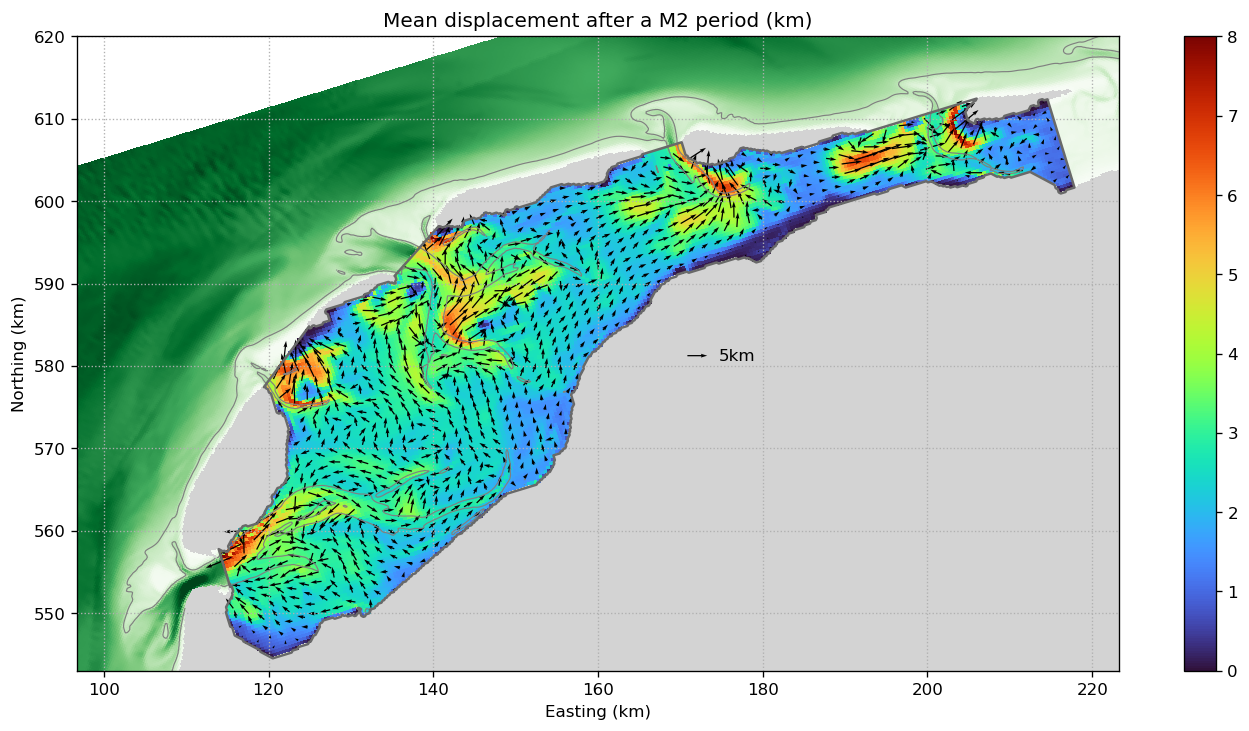

In [300]:
fig,ax= plt.subplots(1,1,figsize=(14,7),dpi=120)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
#
iyy=3;ixx=4
units='height';width=0.002;scale=160  
ax.pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax.pcolormesh(xcdisp,ycdisp,dis_mag_mean,vmin=0,vmax=8,shading='auto',cmap="turbo") #wind correct orientation
plt.colorbar(aa,ax=ax)
ax.contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=.7) #bathy from topo file correct orientation
ax.plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'dimgrey') #DWS limits
ax.axis('equal');ax.axis([100,220,543,620]);ax.grid(ls=":")
ax.set_xlabel('Easting (km)');ax.set_ylabel('Northing (km)');
ax.set_title('Mean displacement after a M2 period (km)');
#vel_from_local_coords_to_projection
dis_dx_meanp,dis_dy_meanp=model_local_coords_to_projection(dis_dx_mean,dis_dy_mean)
Q = ax.quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx_meanp[::iyy,::ixx],dis_dy_meanp[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax.quiverkey(Q, 0.5, 0.5, 5, '5km', labelpos='E',coordinates='figure');
#
# ax.plot(xytp[0,0],xytp[0,1],'or',markersize=5,markeredgecolor='k') 
# ax.text(xytp[0,0],xytp[0,1],'Texel',color='k',weight='bold',ha='center') 
# ax.plot(xyvp[0,0],xyvp[0,1],'or',markersize=5,markeredgecolor='k') 
# ax.text(xyvp[0,0],xyvp[0,1],'Vlie',color='k',weight='bold',ha='center') ;

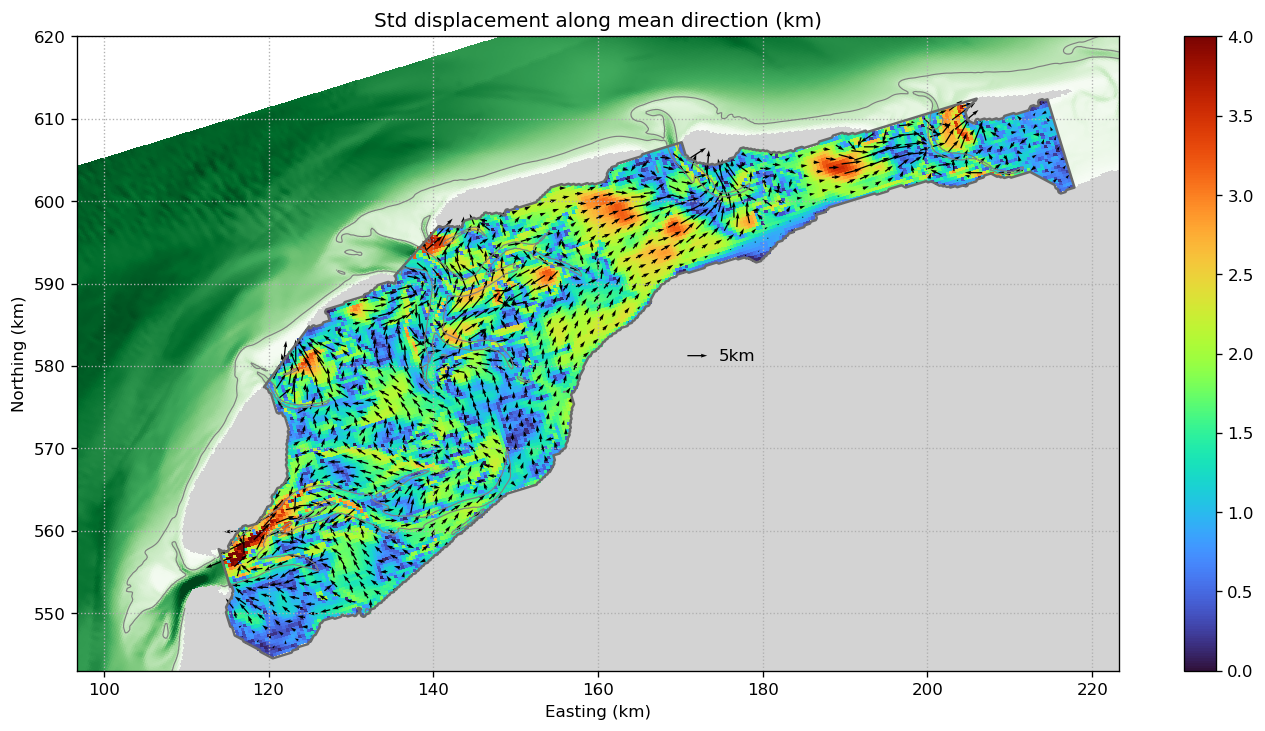

In [66]:
fig,ax= plt.subplots(1,1,figsize=(14,7),dpi=120)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
#
iyy=3;ixx=4
units='height';width=0.002;scale=160  
ax.pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax.pcolormesh(xcdisp,ycdisp,dis_mag_std,vmin=0,vmax=4,shading='auto',cmap="turbo") #wind correct orientation
plt.colorbar(aa,ax=ax)
ax.contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=.7) #bathy from topo file correct orientation
ax.plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'dimgrey') #DWS limits
ax.axis('equal');ax.axis([100,220,543,620]);ax.grid(ls=":")
ax.set_xlabel('Easting (km)');ax.set_ylabel('Northing (km)');
ax.set_title('Std displacement along mean direction (km)');
#vel_from_local_coords_to_projection
dis_dx_meanp,dis_dy_meanp=model_local_coords_to_projection(dis_dx_mean,dis_dy_mean)
Q = ax.quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx_meanp[::iyy,::ixx],dis_dy_meanp[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax.quiverkey(Q, 0.5, 0.5, 5, '5km', labelpos='E',coordinates='figure');

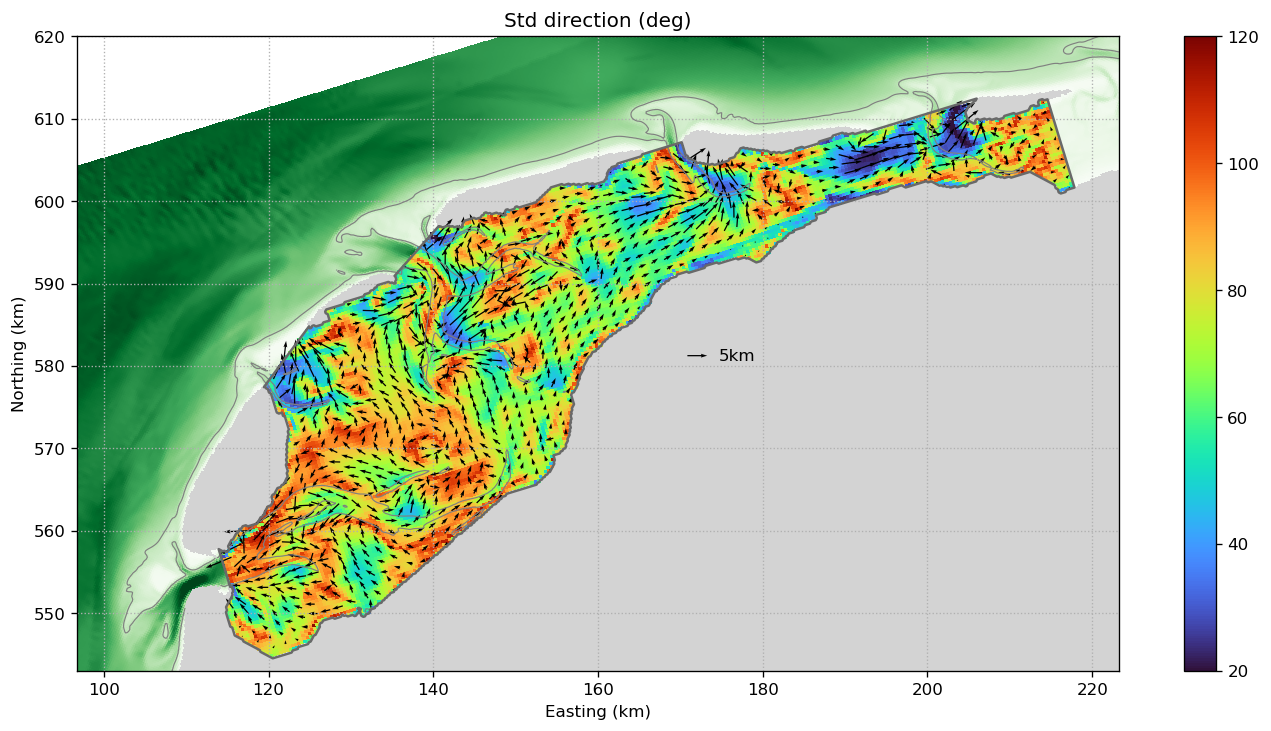

In [293]:
fig,ax= plt.subplots(1,1,figsize=(14,7),dpi=120)
#
#background map
cmap = mpl.cm.get_cmap("Greens").copy()
cmap.set_bad(color='lightgrey')
#
iyy=3;ixx=4
units='height';width=0.002;scale=160  
ax.pcolormesh(xctp,yctp,dsto.bathymetry,vmin=-2,vmax=30,shading='auto',cmap=cmap)
aa=ax.pcolormesh(xcdisp,ycdisp,dis_ang_std*180/np.pi,vmin=20,vmax=120,shading='auto',cmap="turbo") #wind correct orientation
plt.colorbar(aa,ax=ax)
ax.contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=.7) #bathy from topo file correct orientation
ax.plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'dimgrey') #DWS limits
ax.axis('equal');ax.axis([100,220,543,620]);ax.grid(ls=":")
ax.set_xlabel('Easting (km)');ax.set_ylabel('Northing (km)');
ax.set_title('Std direction (deg)');
#vel_from_local_coords_to_projection
dis_dx_meanp,dis_dy_meanp=model_local_coords_to_projection(dis_dx_mean,dis_dy_mean)
Q = ax.quiver(xcdisp[::iyy,::ixx],ycdisp[::iyy,::ixx],dis_dx_meanp[::iyy,::ixx],dis_dy_meanp[::iyy,::ixx],units=units,width=width,scale=scale,color='k')
qk = ax.quiverkey(Q, 0.5, 0.5, 5, '5km', labelpos='E',coordinates='figure');
#ax.plot(xcdisp[(iy1,ix1)],ycdisp[(iy1,ix1)],"om",ms=5)